In [4]:
import network_stats as ns
import network_manipulation as nm
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import odeint
import random

# should make this into a file to inport into every notebook
dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

In [268]:
def initialise_potential(G, initial, threshold): #look into more initialisation schemes
    nodes = list(G.nodes)
    for node in nodes:
        if random.random() < initial:
            G.nodes[node]['potential'] = threshold 
        else:
            G.nodes[node]['potential'] = 0
    return G

def initialise_status(G):
    '''
    1   :   susceptible
    0   :   infected
    -1  :   removed
    '''
    nodes = list(G.nodes)
    for node in nodes:
        if G.nodes[node]['potential'] == 0:
            G.nodes[node]['status'] = 1
        else:
            G.nodes[node]['status'] = 0
    return G

def initialise_weight(G, weight):
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = weight
    return G

In [477]:
def propagate(G, threshold, beta, gamma): # only fires if newly infected, no decay of potential
    nodes = list(G.nodes)
    
    update_dict = {}
    for node in nodes: # initialise dict to keep track of which nodes need to be updated and by how much
        update_dict[node] = 0
    
    for node in nodes: # finding which potential to increase
        if G.nodes[node]['status'] == 0: # if node is infected it should transmit disease and have prob of becoming recovered, first as these are actors
            connections = list(G.neighbors(node))
            for connection in connections:
                update_dict[connection] += beta * G[node][connection]['weight'] 
                
            #comp = 1 - np.exp(-gamma)
            comp = gamma
            
            if np.random.random() < comp: # some chance for infected nodes to become removed nodes
                G.nodes[node]['status'] = -1
    
    for node in nodes: # carrying out updates by looping over all susceptible nodes to increase potentials
        if G.nodes[node]['status'] == 1: # if a node is susceptible, it should be able to gain potential and can become infected
            G.nodes[node]['potential'] += update_dict[node]
            if G.nodes[node]['potential'] >= threshold: # if update pushes above threshold then infected
                G.nodes[node]['status'] = 0
            else: # otherwise there is decay
                pot = G.nodes[node]['potential']
                #decay = pot * np.exp(-pot / threshold)
                decay = 30
                G.nodes[node]['potential'] -= decay

    return G


In [270]:
def check_activity(G, threshold): # cumsum of infected nodes
    infected = 0
    nodes = list(G.nodes)
    for node in nodes:
        if G.nodes[node]['potential'] >= threshold:
            infected += 1
    return infected / len(G.nodes)

def check_activity(G): # cumsum of infected nodes
    total = 0
    nodes = list(G.nodes)
    for node in nodes:
        if  G.nodes[node]['status'] == 0:
            total+=1
    return total / len(G)

def check_removed(G):
    total = 0
    nodes = list(G.nodes)
    for node in nodes:
        if  G.nodes[node]['status'] == -1:
            total+=1
    return total / len(G)

def check_susecptible(G): # finds what fraction of nodes are susceptible
    total = 0
    nodes = list(G.nodes)
    for node in nodes:
        if  G.nodes[node]['status'] == 1:
            total+=1
    return total / len(G)

def check_states(G):
    s = check_susecptible(G)
    i = check_activity(G)
    r = check_removed(G)
    return s, i, r

def simulate(G, initial, threshold, T, beta, gamma): # add in infected per time step later
    susceptible = []
    infected = []
    removed = []
    
    G = initialise_potential(G, initial, threshold)
    G = initialise_status(G)
    
    s, i, r = check_states(G)
    susceptible.append(s)
    infected.append(i)
    removed.append(r)
    
    for t in range(T):
        G = propagate(G, threshold, beta, gamma)
        s, i, r = check_states(G)
        susceptible.append(s)
        infected.append(i)
        removed.append(r)
        
    return susceptible, infected, removed

def smooth(G, initial, threshold, T, M, beta, gamma):
    s_smooth = []
    i_smooth = []
    r_smooth = []
    s_runs = []
    i_runs = []
    r_runs = []
    for i in range(M):
        #print(str(round((i+1)*100/M, 1)) + '%') # display progress of smoothing
        s_run, i_run, r_run = simulate(G, initial, threshold, T, beta, gamma)
        s_runs.append(s_run)
        i_runs.append(i_run)
        r_runs.append(r_run)
    
    for i in range(T): # smoothing susceptible time series
        total = 0
        for j in range(M):
            total += s_runs[j][i]     
        total = total / M   
        s_smooth.append(total)
        
    for i in range(T): # smoothing infected time series
        total = 0
        for j in range(M):
            total += i_runs[j][i]     
        total = total / M   
        i_smooth.append(total)

    for i in range(T): # smoothing recovered time series
        total = 0
        for j in range(M):
            total += r_runs[j][i]     
        total = total / M   
        r_smooth.append(total)
        
    return s_smooth, i_smooth, r_smooth

In [1044]:
# SIR analytical solution

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def analytic_sol(G, params):
    N = len(G)
    I0 = np.ceil(params['Initial'] * N)
    R0 = 0
    S0 = N - I0 - R0
    t = np.arange(0, params['Time'], 1)
    y0 = S0, I0, R0 # Initial conditions vector
    ret = odeint(deriv, y0, t, args=(N, params['Beta'], params['Gamma']))
    S, I, R = ret.T
    return S/N, I/N, R/N

def comparison(G, params, name = 'Placeholder'):
    plt.figure(figsize=(8, 6))
    plt.grid()
    #plt.ylim(0, 1.2)
    analytic_time = np.arange(0, params['Time'])
    S, I, R = analytic_sol(G, params)

    plt.plot(analytic_time, S, linewidth = 3, label = 'Susceptible', color = 'b', linestyle = 'dashed', alpha = 1)
    plt.plot(analytic_time, I, linewidth = 3, label = 'Infected', color = 'r', linestyle = 'dashed', alpha = 1)
    plt.plot(analytic_time, R, linewidth = 3, label = 'Recovered', color = 'g', linestyle = 'dashed', alpha = 1)
    
    #eqn_infected = np.cumsum(I)
    #plt.plot(analytic_time, eqn_infected, linewidth = 3, label = 'Infected', color = 'r')
    
    sim_time = np.arange(0, params['Time'])
    s_sim, i_sim, r_sim = smooth(G, params['Initial'], params['Threshold'], params['Time'], params['Runs'], params['Beta'], params['Gamma'])
    

    plt.plot(sim_time, s_sim, color = 'b')
    plt.plot(sim_time, i_sim,  color = 'r')
    plt.plot(sim_time, r_sim,  color = 'g')
    
    #sim_infected = np.cumsum(i_sim)
    #plt.plot(sim_time, sim_infected, label = name)
    
    plt.legend(loc = 'center right')
    plt.title('Neuron SIR (beta = ' + str(params['Beta']) + ') (Gamma = ' + str(params['Gamma']) + ') (Threshold = ' + str(params['Threshold']) + ')')
    plt.show()
       
    #print('Final simulated infected: ' + str(sim_infected[-1]))
    #print('Final analytic infected: ' + str(eqn_infected[-1]))
    
    return G

In [228]:
# SI analytical solution

def analytic_sol(x, beta, c):
    return np.exp(beta*x+c) / (1 + np.exp(beta*x+c))

def integration_const(initial):
    return np.log(initial/(1-initial))

def comparison(G, params, name = 'Placeholder'):
    plt.figure()
    analytic_time = np.arange(0, params['Time'], params['Increment'])
    const = integration_const(params['Initial'])
    analytic_activity = analytic_sol(analytic_time, params['Beta'], const)
    plt.plot(analytic_time, analytic_activity, linewidth = 3, label = 'Analytical')
    
    sim_activity = smooth(G, params['Initial'], params['Threshold'], params['Time'], params['Runs'], params['Beta'], params['Decay'])
    sim_time = np.arange(0, params['Time'], 1)
    plt.plot(sim_time, sim_activity, label = name)
    
    plt.legend(loc = 'lower right')
    plt.title('SI model comparison (beta = ' + str(params['Beta'])+ ') (Threshold = ' + str(params['Threshold']) + ')')
    plt.show()
    
    print('Final infected: ' + str(sim_activity[-1]))
    
    return G

In [397]:
G = nm.build_nxgraph(dataset_paths[3], False) 

node_measures = ns.measure_nodes(G)
network_measures = ns.measure_network(G)

print('Node measures')
ns.print_dict(node_measures)
print('Network measures')
ns.print_dict(network_measures)

Node measures
degree : 17.792048929663608
weight : 64.80165005156411
closeness : 152.51139972965692
betweenness : 1.1665691363850876
eigenvector : 16.501379789393575


Network measures
nodes : 327
edges : 5818
ratio : 17.792048929663608
components : 1
density : 0.10915367441511416
path : 2.1594341569576554
diameter : 4
transitivity : 0.44442135612150807




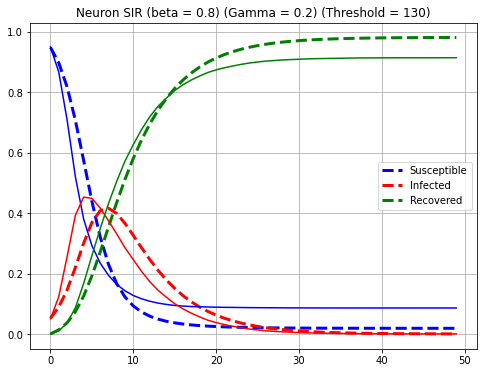

Fraction unfired: 0.0672782874617737


In [1045]:
simulation_params = {}

simulation_params['Time'] = 40
simulation_params['Runs'] = 100

simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2

simulation_params['Threshold'] = 65*2 # only affects simulation

#simulation_params['Increment'] = 0.1 # unused
#simulation_params['Decay'] = 1 # not reall IF , should be some kind of expnenetial

G = nm.build_nxgraph(dataset_paths[3], False) 
#G = nx.erdos_renyi_graph(1000, 0.15)
#G = initialise_weight(G, 1)
G = comparison(G, simulation_params, 'original')
print('Fraction unfired: ' + str(check_susecptible(G)))


In [446]:
print(check_states(G))

(0.14984709480122324, 0.0, 0.8501529051987767)


In [354]:
# Figure out why analytical solution and model go beyond population size for certain parameters
# See if decay is holding back accuracy
# visualise spread for presentation
# for future, give better estimates on dates and timescales over which we expect change and account for features like weekends and holidays.

0.8957816377171216

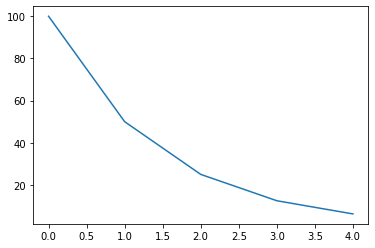

In [168]:
plt.plot([0, 1, 2, 3, 4], [100, 50, 25, 12.5, 6.25])


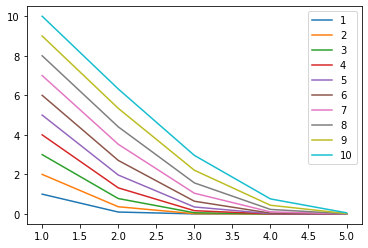

In [481]:
th = 10

for i in range(1,11):
    pot = i
    x = np.linspace(1, 5, 5) # time
    y = [pot]
    for j in range(len(x)-1):
        y.append(pot - pot*np.exp(-pot/th))
        pot = y[-1]

    plt.plot(x, y, label = i)
    plt.legend(loc = 'upper right')

In [428]:
1-np.exp(-0.4)

0.3296799539643607

In [971]:
def initialise_basic(H, params):
    for node in list(H.nodes): # initialise 
        if np.random.random() < params['Initial']: # infect some percentage of nodes
            H.nodes[node]['status'] = 0
        else:
            H.nodes[node]['status'] = 1
    return H

def basic_sir(H, params):
    H = initialise_basic(H, params)
    
    S = []
    I = []
    R = []
    s, i, r = check_states(H)
    S.append(s)
    I.append(i)
    R.append(r)
    
    for i in range(params['Time']):
        
        update_list = []
        count = 0
        
        for node in list(H.nodes):
        
            if H.nodes[node]['status'] == 0:
                
                connections = list(H.neighbors(node))
                
                for connection in connections:
                    
                    stat = params['Beta'] * H[node][connection]['weight']
                    
                    if np.random.random() < stat:
                        
                        count += 1
                        #H.nodes[connection]['status'] = 0
                        update_list.append(connection)
        #print(stat)
        #print(count)
        #print(check_activity(H)*len(H))
        
        for node in list(H.nodes):
            if H.nodes[node]['status'] == 0:
                if np.random.random() < params['Gamma']:
                    H.nodes[node]['status'] = -1
                    
        for node in update_list:
            if H.nodes[node]['status'] == 1:
                H.nodes[node]['status'] = 0 
                    
        s, i, r = check_states(H)
        S.append(s)
        I.append(i)
        R.append(r)
        
    return S, I, R

        
def smooth_basic(H, params):
    s_smooth = []
    i_smooth = []
    r_smooth = []
    s_runs = []
    i_runs = []
    r_runs = []
    
    M = params['Runs']
    T = params['Time']
    
    for i in range(M):
        #print(str(round((i+1)*100/M, 1)) + '%') # display progress of smoothing
        s_run, i_run, r_run = simulate_sir(H, params)
        s_runs.append(s_run)
        i_runs.append(i_run)
        r_runs.append(r_run)
    
    for i in range(T): # smoothing susceptible time series
        total = 0
        for j in range(M):
            total += s_runs[j][i]     
        total = total / M   
        s_smooth.append(total)
        
    for i in range(T): # smoothing infected time series
        total = 0
        for j in range(M):
            total += i_runs[j][i]     
        total = total / M   
        i_smooth.append(total)

    for i in range(T): # smoothing recovered time series
        total = 0
        for j in range(M):
            total += r_runs[j][i]     
        total = total / M   
        r_smooth.append(total)
        
    return s_smooth, i_smooth, r_smooth
    
def rescale_weights(H):
    weights = []
    
    for node in list(H.nodes):
        connections = H.neighbors(node)
        for connection in connections:
            old = H[node][connection]['weight']
            new = np.log10(old)
            weights.append(new)
            H[node][connection]['weight'] = new
    
    norm = max(weights)
    print(norm)
    
    for node in list(H.nodes):
        connections = H.neighbors(node)
        for connection in connections:
            H[node][connection]['weight'] /= norm
    
    return H
    
            
def test_sir(H, params): # runs 1 time step
    update_dict = {}
    #print(len(update_dict)/ len(G))
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            connections = list(H.neighbors(node))
            for connection in connections:
                stat = H[node][connection]['weight'] * params['Beta']
                if np.random.random() < stat:
                    update_dict[connection] = 0
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < params['Gamma']:
                H.nodes[node]['status'] = -1
    #print(len(update_dict)/ len(G))
    for node in list(update_dict.keys()):
        if H.nodes[node]['status'] == 1:
            H.nodes[node]['status'] = 0
    return H

def simulate_sir(H, params):
    H = initialise_basic(H, params)
    S = []
    I = []
    R = []
    s, i, r = check_states(H)
    S.append(s)
    I.append(i)
    R.append(r)
    for i in range(params['Time']):
        H = test_sir(H, params)
        s, i, r = check_states(H)
        S.append(s)
        I.append(i)
        R.append(r)
    return S, I, R
    
    

(0.6483180428134556, 0.01529051987767584, 0.3363914373088685)


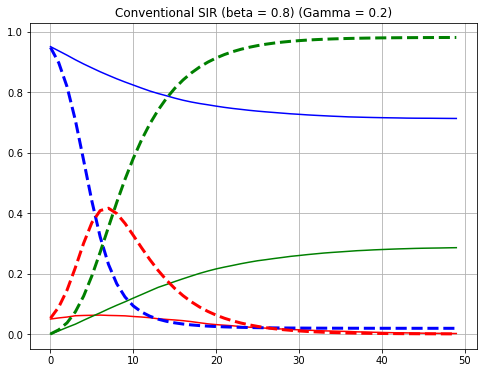

In [1046]:
# Numerical SIR

# infect some part of the population then start to move through time from data.
simulation_params = {}

simulation_params['Time'] = 50
simulation_params['Runs'] = 100

simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2

H = nm.build_nxgraph(dataset_paths[3], True) 
#H = initialise_weight(H, 1)
#H = rescale_weights(H)
s, i, r = smooth_basic(H, simulation_params)
t = np.arange(0, simulation_params['Time'])
plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ')')


plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')


S, I, R = analytic_sol(G, simulation_params)

plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

  
plt.grid()
#plt.legend(loc = 'upper right')
print(check_states(H))

In [949]:
simulation_params = {}

simulation_params['Time'] = 10
simulation_params['Runs'] = 1

simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.5
simulation_params['Gamma'] = 0.3

H = nm.build_nxgraph(dataset_paths[3], True) 
print(len(H))
#H = initialise_weight(H, 1)
H = initialise_basic(H, simulation_params)
print(check_states(H))
H = test_sir(H, simulation_params)
print(check_states(H))


327
(0.9418960244648318, 0.0581039755351682, 0.0)
2
(0.9357798165137615, 0.03669724770642202, 0.027522935779816515)


In [742]:
simulation_params = {}

simulation_params['Time'] = 10
simulation_params['Runs'] = 1

simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.5
simulation_params['Gamma'] = 0.3


H = nm.build_nxgraph(dataset_paths[3], True) 

#d, w = ns.analyse_graph(H)
#plt.hist(w)

H = initialise_weight(H, 1)
H = initialise_basic(H, simulation_params)

#d, w = ns.analyse_graph(H)
#plt.hist(w)

params = simulation_params

update_dist = {}
count = 0
total = 0
sum = 0
print(check_activity(H))
    
print(check_activity(H))

print(sum) # num infected
print(total)
print(count)

# the problem is occurring because the same connections can be counted for multiple infected nodes

0.039755351681957186
0.08256880733944955
1
26
15


In [936]:
def test_sir(H):
    update_list = []
    
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            connections = list(H.neighbors(node))
            for connection in connections:
                stat = H[node][connection]['weight'] * 0.5
                if np.random.random() < stat:
                    update_list.append(connection)
    
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < 0.5:
                H.nodes[node]['status'] = -1
    
    print(update_list)
    for node in update_list:
        if H.nodes[node]['status'] == 1:
            H.nodes[node]['status'] = 0 
    
    return H



T = nx.Graph()
T.add_edge(0,1)
T.add_edge(0,2)
T.add_edge(1,2)
T[0][1]['weight'] = 1
T[0][2]['weight'] = 1
T[1][2]['weight'] = 1

T.nodes[0]['status'] = 0
T.nodes[1]['status'] = 1
T.nodes[2]['status'] = 1

for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

T = test_sir(T)
for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

T = test_sir(T)
for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

T = test_sir(T)
for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

T = test_sir(T)
for node in list(T.nodes):
    if T.nodes[node]['status'] == 0:
        connections = list(T.neighbors(node))
    print(str(node) + ' : ' + str(T.nodes[node]))
print('\n')

0 : {'status': 0}
1 : {'status': 1}
2 : {'status': 1}


[1]
0 : {'status': 0}
1 : {'status': 0}
2 : {'status': 1}


[2]
0 : {'status': 0}
1 : {'status': -1}
2 : {'status': 0}


[2]
0 : {'status': 0}
1 : {'status': -1}
2 : {'status': 0}


[2]
0 : {'status': -1}
1 : {'status': -1}
2 : {'status': 0}


